## PCA TASK
- Load Data

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import decomposition
from pca_helper_functions import *
%matplotlib inline


# Load the datasets from the saved numpy arrays in the Familiarization task
X = np.load('./train_data.npy')
y = np.load('./train_labels.npy')
X_test = np.load('./test_data.npy')

train_data = pd.read_pickle('./train_data_df.pkl')

# Seperate the two training datasets
# X1, y1 = training data and labels 1 (normal behaviour)
# X2, y2 = training data and labels 2 (attacks present)
num = 8761
X1 = X[:num]
X2 = X[num:]
y1 = y[:num]
y2 = y[num:]

# Check that everything is there
print("Training dataset shape: ", X.shape)
print("Test dataset shape: ", X_test.shape)
print("Number of attacks: ", np.sum(y==1))

Training dataset shape:  (12938, 40)
Test dataset shape:  (2089, 40)
Number of attacks:  219


### Find the optimal number of Principal Components 

- 1st Normalize the normal data to have zero mean.

- Apply PCA on the normal data without anomalies.

- Use the number of components that was calculated based on the paper "Diagnosing Network-Wide Traffic Anomalies".


In [2]:
#Normalize- apply model 
normalize = StandardScaler()
n_data = normalize.fit_transform(X1)

#model = PCA( n_components= X1.shape[1])
#p_data = model.fit_transform(n_data)
#r_data = model.inverse_transform(p_data)
# Function which determines the number of components to use 
num, P_n, P_an = determine_num_components(n_data, 3)

print('Number of principal components:', num)


Number of principal components: 2


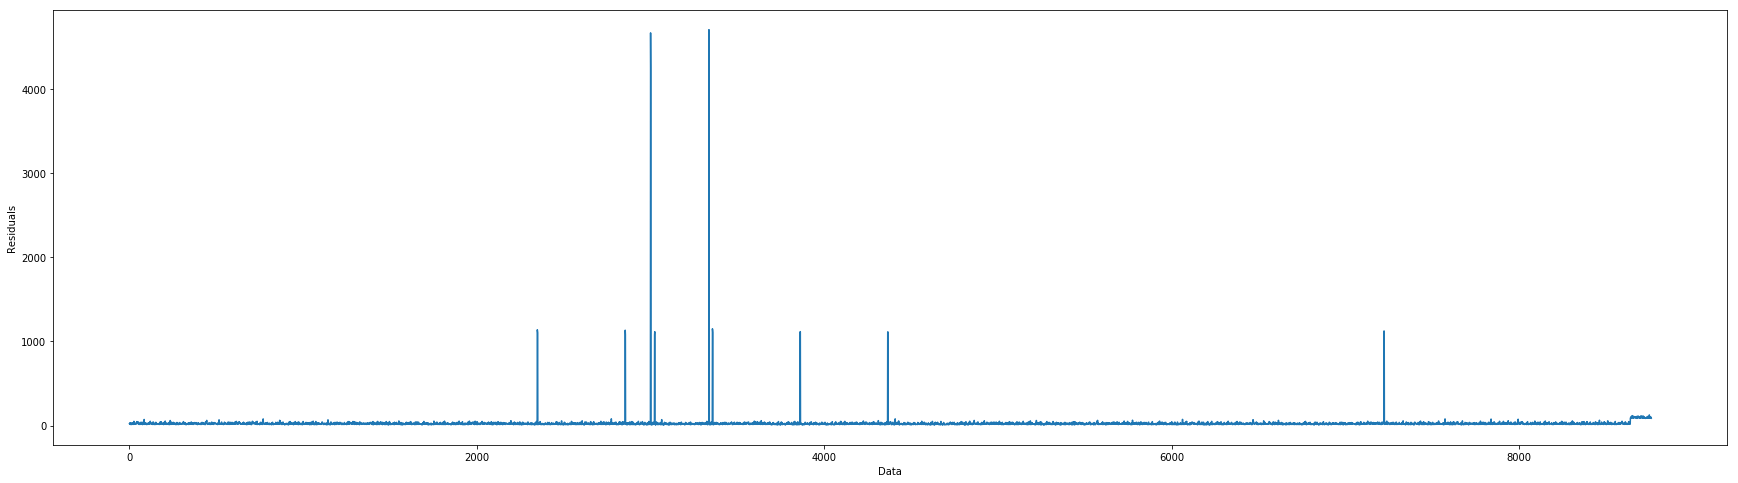

<Figure size 2160x1080 with 0 Axes>

In [3]:
#compute the residual(spe) from the P_n and P_an
res = residuals(n_data, P_n, P_an)

#visualize the results 
figure, ax = plt.subplots(figsize=[30,8])
plt.xlabel("Data")
plt.ylabel("Residuals")
plt.figure(figsize=[30,15])
ax.plot(res)

- The figure above shows that there are abnormalities in the train data. We need to remove them.



Cleaned data new shape: (8610, 40)


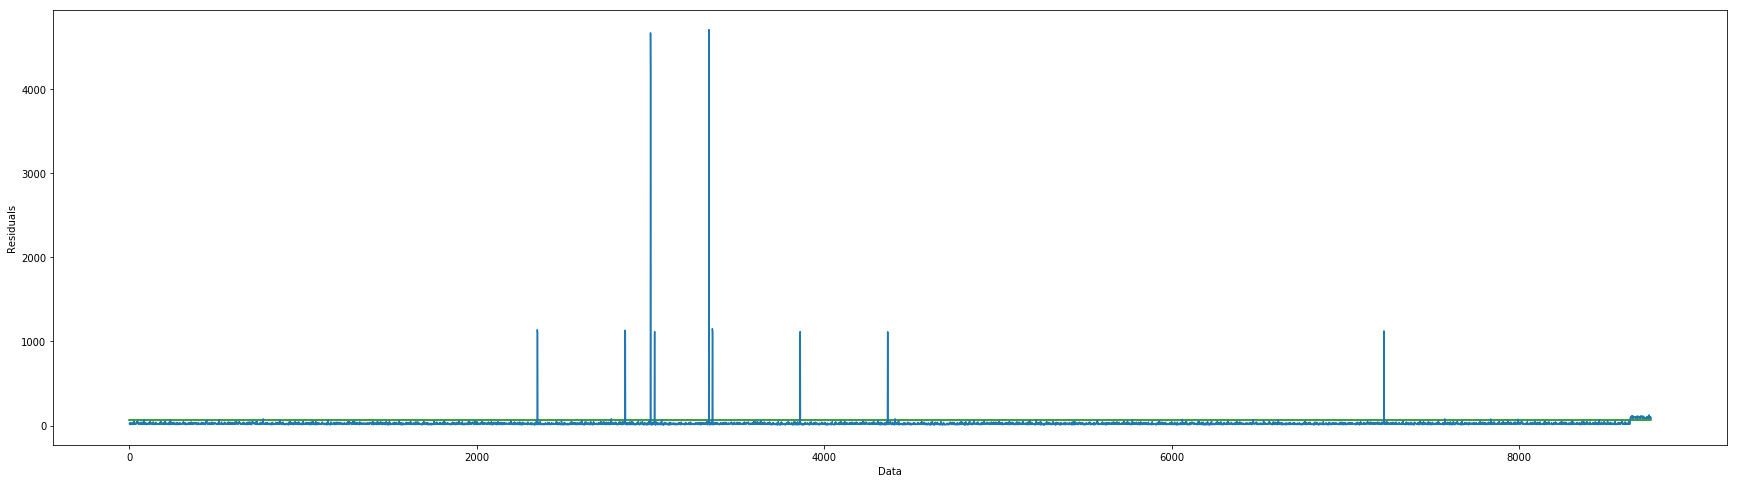

<Figure size 2160x1080 with 0 Axes>

In [4]:
#We defined a threshold according to the res in order to remove the large spikes
outlier_threshold = 70

figure, ax = plt.subplots(figsize=[30,8])
plt.xlabel("Data")
plt.ylabel("Residuals")
plt.figure(figsize=[30,15])
ax.plot([0,len(res)],[outlier_threshold, outlier_threshold],'g', label = 'decision' )
ax.plot(res)

# We keep the data below
data_without = X1[res<=outlier_threshold]
print('Cleaned data new shape:', data_without.shape)
    

- Follow the same procedure for the new train data

Number of principal components: 2


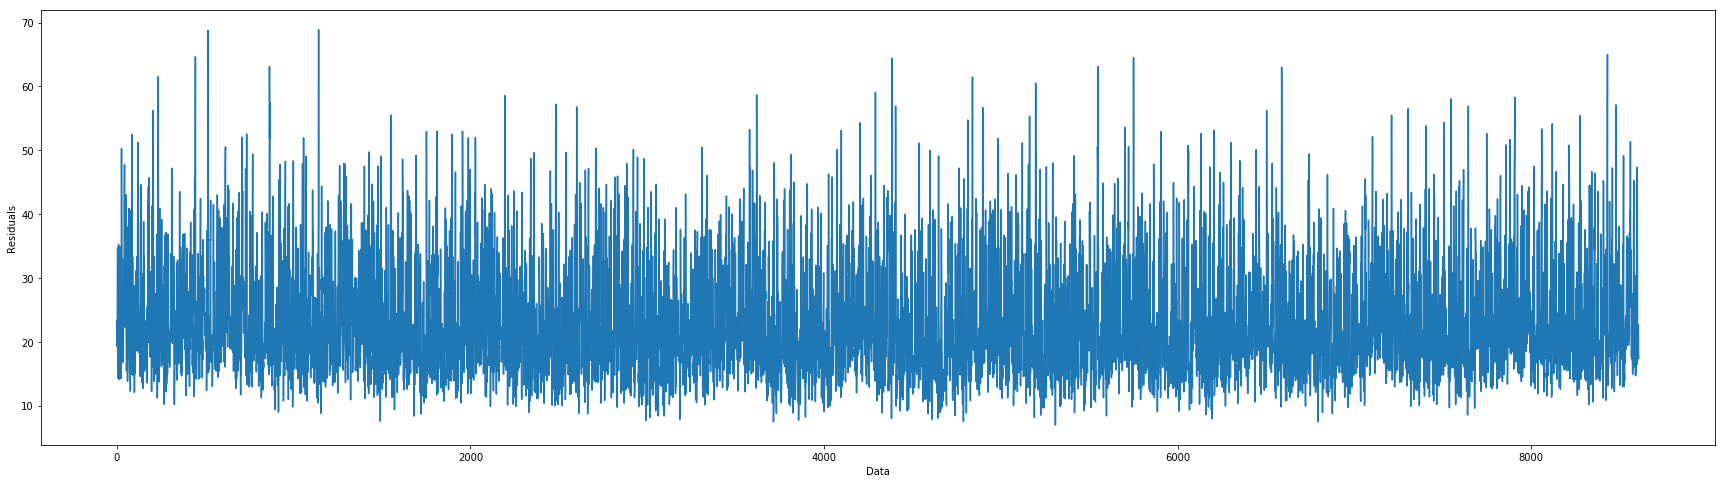

<Figure size 2160x1080 with 0 Axes>

In [5]:
#Normalize
norm = StandardScaler()
n_data2 = normalize.fit_transform(data_without)

#Finds the number of components to use 
num2, P_n2, P_an2 = determine_num_components(n_data2, 3)

print('Number of principal components:', num2)

#computes the residual(spe) from the P_n and P_an
res2 = residuals(n_data2, P_n2, P_an2)

#visualize the results 
figure, ax = plt.subplots(figsize=[30,8])
plt.xlabel("Data")
plt.ylabel("Residuals")
plt.figure(figsize=[30,15])
ax.plot(res2)


- We computed the threshold according to the paper "Diagnosing Network-Wide Traffic Anomalies" by et al Lakhina. The threshold is obtained using the Q-Statistic function.

In [6]:
#fit the models to capture the variance
model = PCA(n_components = n_data.shape[1])
model.fit(n_data)
model2 = PCA(n_components = n_data2.shape[1])
model2.fit(n_data2)

#Calculates the thresholds
threshold =  Q_stat(model, num)
threshold2=  Q_stat(model2, num2)

print('Threshold obtained from the original data:', threshold)
print('Threshold obtained from the data without anomalies:', threshold2)


Threshold obtained from the original data: 38.20936596472291
Threshold obtained from the data without anomalies: 32.19315756748568


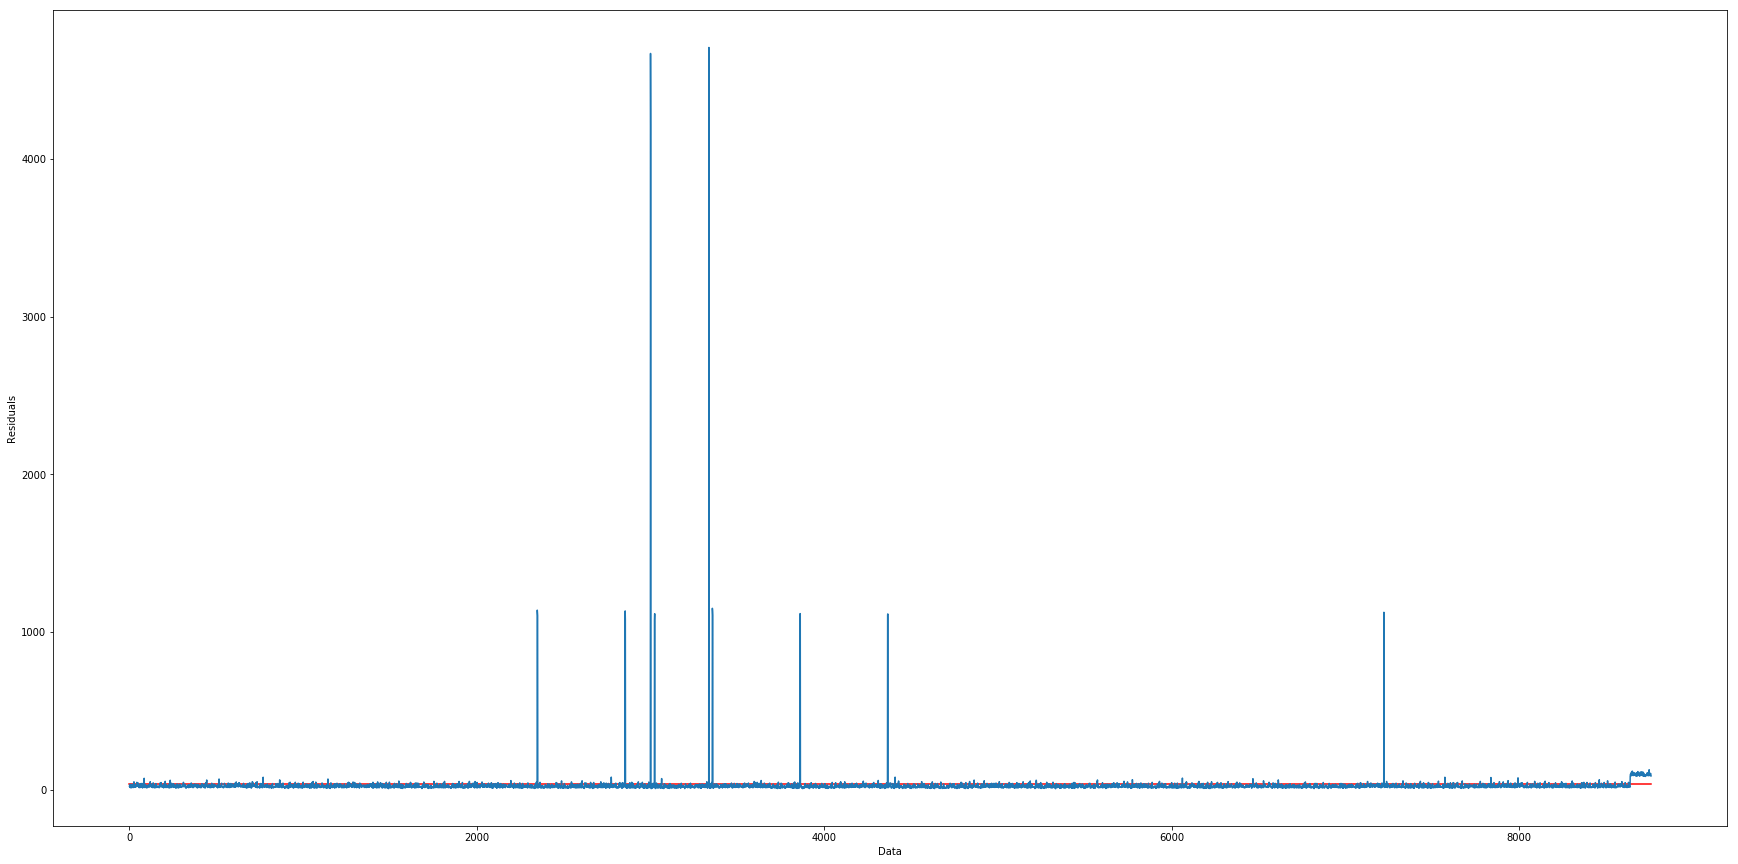

<Figure size 2160x1080 with 0 Axes>

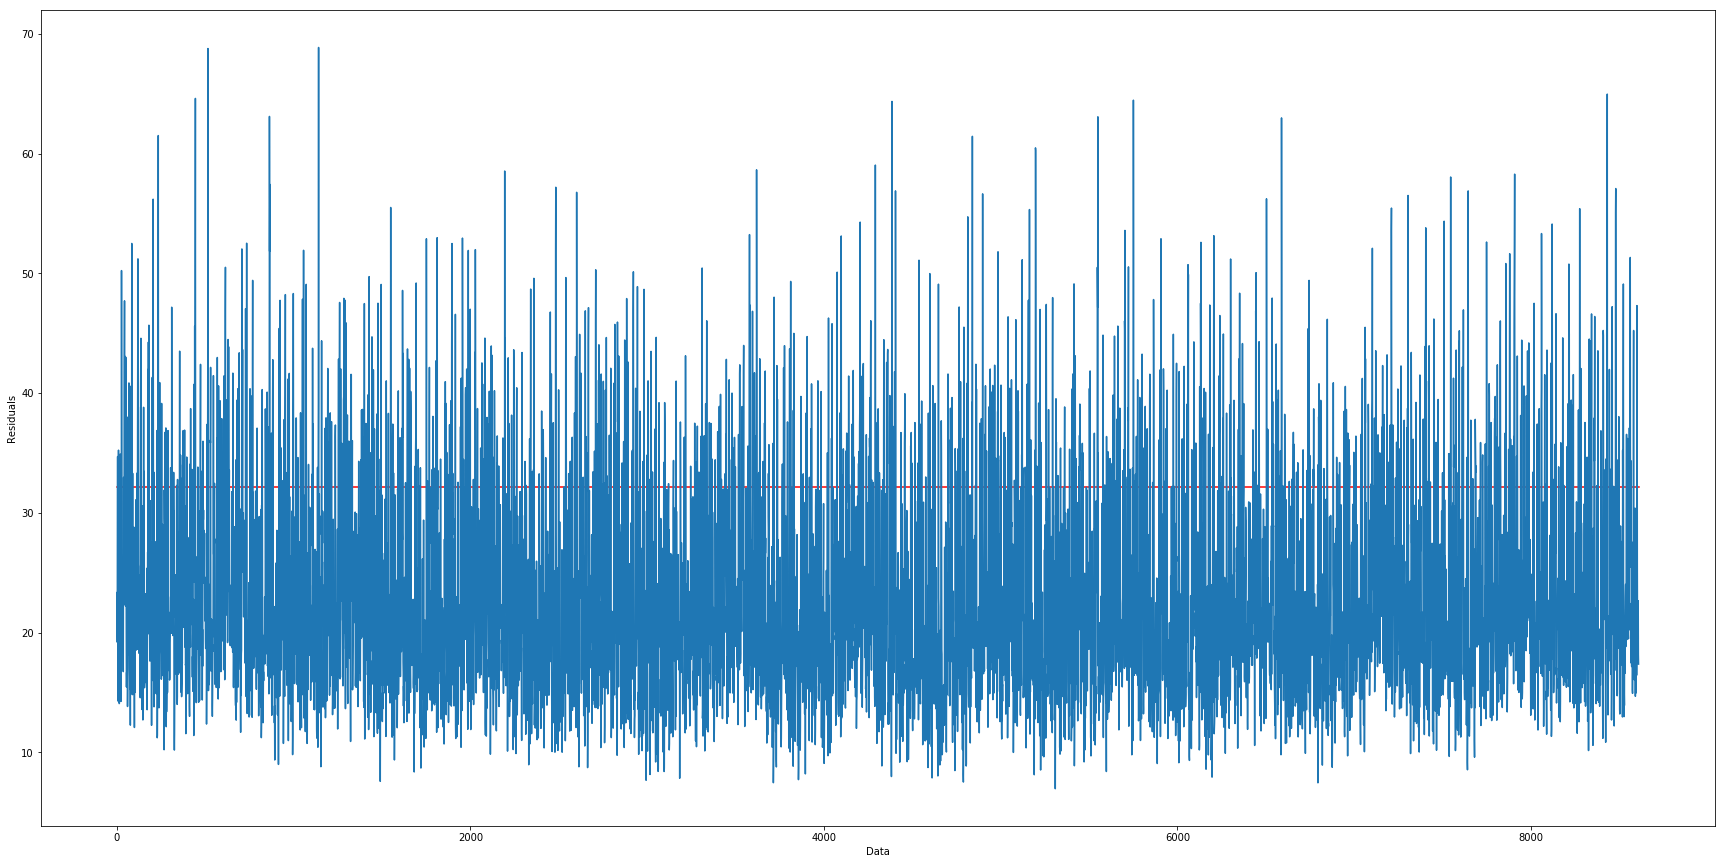

<Figure size 2160x1080 with 0 Axes>

In [7]:
#Visualizations of the obtained thresholds
figure, ax = plt.subplots(figsize=[30,15])
plt.xlabel("Data")
plt.ylabel("Residuals")
plt.figure(figsize=[30,15])
ax.plot([0,len(res)],[threshold, threshold],'r', label = 'qstat' )
ax.plot(res)

figure, ax = plt.subplots(figsize=[30,15])
plt.xlabel("Data")
plt.ylabel("Residuals")
plt.figure(figsize=[30,15])
ax.plot([0,len(res2)],[threshold2, threshold2],'r', label = 'qstat' )
ax.plot(res2)




- Apply the  same number of components and use the same procedure on the test set.
- Normalize again
- Predict the labels based on the projections where res(spe)> threshold is an anomaly

In [8]:
#detect anomalies the fuction returns the predicted labels 
scale = StandardScaler()
att_data = scale.fit_transform(X2)

#detects anomalies the fuction returns the predicted labels  
predicted_labels = det_anomalies(n_data,att_data, num, threshold)

predicted_labels2 = det_anomalies(n_data2,att_data, num2,threshold2)





### Results 
- Calculate the confusion matrix
- Compute Accuracy, Precision, Recall, F1_score 
- Visualize the labels

Confusion Matrix: [[ 109  258]
 [ 110 3700]]
Accuracy: 0.91
Precision: 0.30
Recall: 0.50
F_score: 0.37


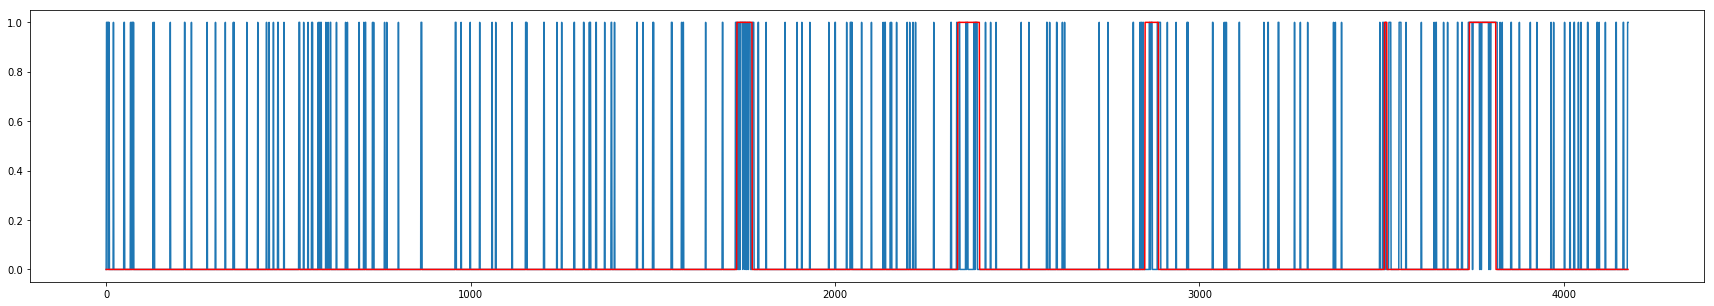

In [14]:
#print results for the first dataset

y2[y2 == -999]= 0
cm = estimate_confusion_matrix(y2, predicted_labels)
accuracy, precision, recall, F1_score = performance_metrics(cm)

    
print ("Confusion Matrix:", cm)
print("Accuracy: %.2f" %accuracy)
print("Precision: %.2f" % precision)
print("Recall: %.2f" %recall)
print("F_score: %.2f" % F1_score)


# Visualize the predicted vs the true labels
figure, ax = plt.subplots(figsize=[30,5])
ax.plot(predicted_labels)# plot the predicted label
ax.plot(y2,'r')# plot the true label


Confusion Matrix: [[ 128  543]
 [  91 3415]]
Accuracy: 0.85
Precision: 0.30
Recall: 0.58
F_score: 0.29


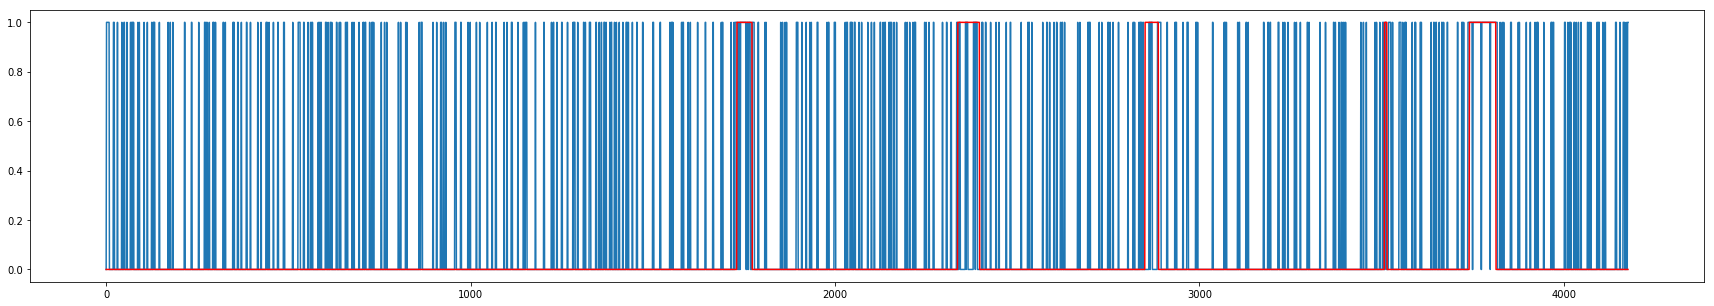

In [16]:
#print results for the dataset without the anomalies

y2[y2 == -999]= 0

# Functions that calculate the confusion matrix and the prediction metrics  
cm2 = estimate_confusion_matrix(y2, predicted_labels2)
accuracy2, precision2, recall2, F1_score2 = performance_metrics(cm2)

 # Print the results    
print ("Confusion Matrix:", cm2)
print("Accuracy: %.2f" %accuracy2)
print("Precision: %.2f" % precision)
print("Recall: %.2f" %recall2)
print("F_score: %.2f" % F1_score2)


# Visualize the predicted vs the true labels
figure, ax = plt.subplots(figsize=[30,5])
ax.plot(predicted_labels2)# plot the predicted label
ax.plot(y2,'r')# plot the true label